
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### Данные для анализа/training:
- `Expression_cells.tsv.gz` - экспрессия очищенных типов нормальных клеток
- `Annotation_cells.tsv.gz` - аннотация
- `Expression_cell_lines.tsv.gz` - экспрессия линий злокачественных клеток различных типов опухолей
- `Annotation_cell_lines.tsv.gz` - аннотация

### Данные для тестирования: - экспрессии 2 образцов крови здоровых пациентов в
- `Normal-blood-expr.tsv` экспрессии 2 образцов крови здоровых пациентов
- `LUAD-expr.tsv` - 6 образцов аденокарциномы
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### Что требуется:
1. Нужно синтезировать из экспрессии очищенных типов клеток (иммунных/стромальных + раковых) искусственные смеси, которые моделировали бы экспрессию опухоли с известным клеточным составом
2. При помощи ML определить клеточный состав нормальных и опухолевых образцов (данные для теста) из данных по экспрессии, используя искусственные смеси для обучения и валидации
3. *Смоделировать возможность экстракции профиля экспрессии опухоли из bulk RNA-seq. Опухоль пациента из-за случайных соматических Transforming cancer treatment
мутаций может иметь любой непредсказуемый профиль экспрессии. Возможно ли, не зная этот профиль заранее, деконволировать его из смеси?
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### Ожидаемый результат:

1. Код по генерации искусственных смесей
2. Код по обучению и валидации модели
3. Отчет по работе модели на тестовых данных
4. Отчет по работе модели по экстракции профиля экспрессии опухоли на тестовых данных.
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder,  StandardScaler, MinMaxScaler 
from sklearn.manifold import  TSNE
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

In [ ]:
! pip install bioinfokit
from bioinfokit.analys import get_data

In [ ]:
# visualize high-dimensional gene expression

data_path = '/home/iuliiasolomennikova/bostone_gene/Kassandra/deconvolution-to-estimate-immune-cell-subsets/data/'
LUAD = pd.read_csv(data_path + 'LUAD-expr.tsv', sep='\t', index_col=0)

pca_scores_LUAD = PCA().fit_transform(LUAD) 
df_pc = pd.DataFrame(pca_scores_LUAD)

tsne_em = TSNE(n_components = 2, perplexity = 10, early_exaggeration = 12, 
               n_iter = 1000, learning_rate = 200, verbose = 1).fit_transform(df_pc) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20062 samples in 0.021s...
[t-SNE] Computed neighbors for 20062 samples in 1.166s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20062
[t-SNE] Computed conditional probabilities for sample 2000 / 20062
[t-SNE] Computed conditional probabilities for sample 3000 / 20062
[t-SNE] Computed conditional probabilities for sample 4000 / 20062
[t-SNE] Computed conditional probabilities for sample 5000 / 20062
[t-SNE] Computed conditional probabilities for sample 6000 / 20062
[t-SNE] Computed conditional probabilities for sample 7000 / 20062
[t-SNE] Computed conditional probabilities for sample 8000 / 20062
[t-SNE] Computed conditional probabilities for sample 9000 / 20062
[t-SNE] Computed conditional probabilities for sample 10000 / 20062
[t-SNE] Computed conditional probabilities for sample 11000 / 20062
[t-SNE] Computed conditional probabilities for sample 12000 / 20062
[t-SNE] Computed conditional probabilities for sam

In [ ]:
# LUAD-expr
from bioinfokit.visuz import cluster
cluster.tsneplot(score=tsne_em)

In [ ]:
# recognize the clusters using the DBSCAN clustering algorithm.

# LUAD-expr
from sklearn.cluster import DBSCAN
get_clusters = DBSCAN(eps = 3, min_samples = 10).fit_predict(tsne_em)
set(get_clusters)

{-1, 0, 1, 2, 3}

In [ ]:
cluster.tsneplot(score=tsne_em, colorlist=get_clusters, legendpos='upper right')
plt.show()

### NORMAL cells:

In [ ]:
NORMAL = pd.read_csv(data_path + 'Normal-blood-expr.tsv', sep='\t', index_col=0)

In [ ]:
pca_scores_NORMAL = PCA().fit_transform(NORMAL)
df_pc = pd.DataFrame(pca_scores_NORMAL)

tsne_em = TSNE(n_components = 2, perplexity = 10, early_exaggeration = 12, 
               n_iter = 1000, verbose = 1).fit_transform(df_pc)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 44792 samples in 0.018s...
[t-SNE] Computed neighbors for 44792 samples in 2.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 44792
[t-SNE] Computed conditional probabilities for sample 2000 / 44792
[t-SNE] Computed conditional probabilities for sample 3000 / 44792
[t-SNE] Computed conditional probabilities for sample 4000 / 44792
[t-SNE] Computed conditional probabilities for sample 5000 / 44792
[t-SNE] Computed conditional probabilities for sample 6000 / 44792
[t-SNE] Computed conditional probabilities for sample 7000 / 44792
[t-SNE] Computed conditional probabilities for sample 8000 / 44792
[t-SNE] Computed conditional probabilities for sample 9000 / 44792
[t-SNE] Computed conditional probabilities for sample 10000 / 44792
[t-SNE] Computed conditional probabilities for sample 11000 / 44792
[t-SNE] Computed conditional probabilities for sample 12000 / 44792
[t-SNE] Computed conditional probabilities for sam

In [ ]:
cluster.tsneplot(score=tsne_em)

In [5]:
import matplotlib
import matplotlib.font_manager

import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

X = NORMAL.values
y = NORMAL.index

get_clusters = DBSCAN(eps=3, min_samples=10).fit_predict(tsne_em)

unique_labels = np.unique(y)
colors = [plt.cm.tab20(i) for i in np.linspace(0, 1, len(unique_labels))]
label_to_color = {label: color for label, color in zip(unique_labels, colors)}
label_colors = [label_to_color[label] for label in y]

# Plot the t-SNE with colors
cluster.tsneplot(score=tsne_em, colorlist=label_colors, legendpos=False)
plt.show()

In [ ]:
set(get_clusters)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

# **Первый подход:**

Разложу матрицу экспрессии на матрицы коэффициентов смешивания и матрицу генных профилей. Мы можем использовать эти коэффициенты смешивания для смешивания экспрессии очищенных типов клеток (иммунных/стромальных + раковых) и создания искусственных смесей, моделирующих экспрессию опухоли.

### Генерация искусственных экспрессий

In [149]:
cancer_sample_annot = pd.read_csv(data_path + 'Annotation_cell_lines.tsv', sep='\t', index_col=0)
cancer_expr = pd.read_csv(data_path + 'Expression_cell_lines.tsv', sep='\t', index_col=0)

cells_sample_annot = pd.read_csv(data_path + '/Annotation_cells.tsv', sep='\t', index_col=0)
cells_expr = pd.read_csv(data_path + 'Expression_cells.tsv', sep='\t', index_col=0)

/home/iuliiasolomennikova/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/iuliiasolomennikova/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/iuliiasolomennikova/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/iuliiasolomennikova/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/iuliiasolomennikova/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number 

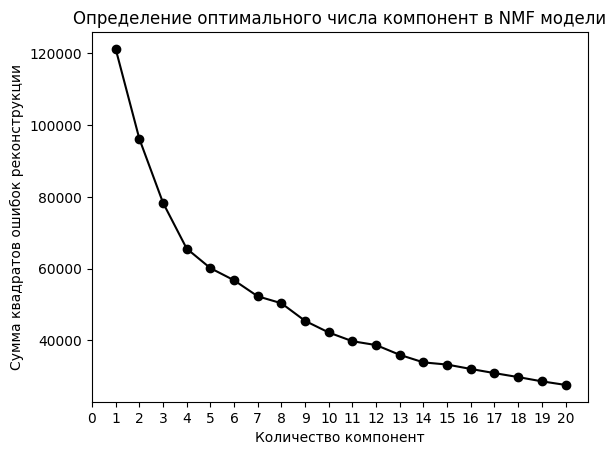

In [314]:
from sklearn.decomposition import NMF

# Определите диапазон числа компонент для проверки
num_components_range = range(1, 21)

# Вычисление суммы квадратов ошибок реконструкции для каждого значения num_components
reconstruction_errors = []
for num_components in num_components_range:
    model = NMF(n_components=num_components, random_state=42)
    model.fit(cells_expr)
    reconstruction_error = model.reconstruction_err_
    reconstruction_errors.append(reconstruction_error)
    
plt.plot(num_components_range, reconstruction_errors, 'o-', color='black')
plt.xlabel('Количество компонент')
plt.ylabel('Сумма квадратов ошибок реконструкции')
plt.title('Определение оптимального числа компонент в NMF модели')
plt.xticks(np.arange(0, 21, step=1))
plt.show()

In [150]:
# Определяем коэффициенты смешивания
from sklearn.decomposition import NMF

# здоровые
num_components = 20
model_cell = NMF(n_components=num_components, random_state=42)
W_cell = model_cell.fit_transform(cells_expr.values)
H_cell = model_cell.components_

In [151]:
# рак
num_components = 20
model_cancer = NMF(n_components=num_components, random_state=42)
W_cancer = model_cancer.fit_transform(cancer_expr.values)
H_cancer = model_cancer.components_


In [154]:
# Создание синтетических смесей рак
synth_expr_cancer = pd.DataFrame(np.dot(W_cancer, H_cancer), index=cancer_expr.index, columns=cancer_expr.columns)
synth_expr_cancer.head(2)

synth_expr_cancer_ = synth_expr_cancer.T
synth_expr_cancer_.head(3)

,srr_cell_0,srr_cell_1,srr_cell_2,srr_cell_3,srr_cell_4,srr_cell_5,srr_cell_6,srr_cell_7,srr_cell_8,srr_cell_9,...,srr_cell_224,srr_cell_225,srr_cell_226,srr_cell_227,srr_cell_228,srr_cell_229,srr_cell_230,srr_cell_231,srr_cell_232,srr_cell_233
A1BG,0.047548,0.041728,0.058604,0.060866,0.049362,0.047491,0.064688,0.059783,0.047776,0.052008,...,0.046174,0.052184,0.052589,0.043515,0.053062,0.050156,0.051326,0.042631,0.052774,0.053672
A1CF,0.148494,0.129947,0.179592,0.186157,0.153339,0.148073,0.198479,0.183243,0.144903,0.157925,...,0.141165,0.160899,0.161830,0.134086,0.162861,0.153608,0.157291,0.131220,0.162067,0.164789
A2M,17.530062,15.260707,20.006957,20.788298,18.286327,17.533388,22.028682,20.414248,17.263924,18.814885,...,16.418780,17.770717,17.908642,14.818535,18.069806,17.079907,17.478438,14.517342,17.971668,18.277273


In [156]:
# Создание синтетических смесей норм
synth_expr_cell = pd.DataFrame(np.dot(W_cell, H_cell), index=cells_expr.index, columns=cells_expr.columns)
synth_expr_cell.head(2)
synth_expr_cell_ = synth_expr_cell.T
synth_expr_cancer_.head(3)

Gene,srr_0,srr_1,srr_2,srr_3,srr_4,srr_5,srr_6,srr_7,srr_8,srr_9,...,srr_978,srr_979,srr_980,srr_981,srr_982,srr_983,srr_984,srr_985,srr_986,srr_987
A1BG,0.005520,0.005432,0.004446,0.005834,0.005234,0.006650,0.005900,0.008453,0.006793,0.005001,...,0.007385,0.012044,0.010286,0.006644,0.040245,0.035910,0.033305,0.038629,0.033820,0.039200
A1CF,0.009050,0.008986,0.007012,0.009807,0.008880,0.011209,0.009656,0.014205,0.011096,0.008412,...,0.011779,0.020249,0.017117,0.010340,0.075868,0.026587,0.033101,0.072849,0.032156,0.038828
A2M,12.621234,11.680805,12.732917,11.064410,9.192849,12.372837,13.659934,16.136755,15.928506,9.462351,...,19.848847,22.690487,20.985238,20.268335,0.224849,382.179183,275.935810,0.000000,293.778286,326.013241


In [160]:
synth_expr_cancer_.index.name = None

In [163]:
synth_expr_cancer_.index.name = 'Gene'
synth_expr_cancer_.head(3)

,srr_cell_0,srr_cell_1,srr_cell_2,srr_cell_3,srr_cell_4,srr_cell_5,srr_cell_6,srr_cell_7,srr_cell_8,srr_cell_9,...,srr_cell_224,srr_cell_225,srr_cell_226,srr_cell_227,srr_cell_228,srr_cell_229,srr_cell_230,srr_cell_231,srr_cell_232,srr_cell_233
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.047548,0.041728,0.058604,0.060866,0.049362,0.047491,0.064688,0.059783,0.047776,0.052008,...,0.046174,0.052184,0.052589,0.043515,0.053062,0.050156,0.051326,0.042631,0.052774,0.053672
A1CF,0.148494,0.129947,0.179592,0.186157,0.153339,0.148073,0.198479,0.183243,0.144903,0.157925,...,0.141165,0.160899,0.161830,0.134086,0.162861,0.153608,0.157291,0.131220,0.162067,0.164789
A2M,17.530062,15.260707,20.006957,20.788298,18.286327,17.533388,22.028682,20.414248,17.263924,18.814885,...,16.418780,17.770717,17.908642,14.818535,18.069806,17.079907,17.478438,14.517342,17.971668,18.277273


In [164]:
# rename indexes in synth_expr_cell and set indexes name as Gene
synth_expr_cancer_ = synth_expr_cancer.T
synth_expr_cancer_.index.name = 'Gene'
synth_expr_cancer_.head(3)

,srr_cell_0,srr_cell_1,srr_cell_2,srr_cell_3,srr_cell_4,srr_cell_5,srr_cell_6,srr_cell_7,srr_cell_8,srr_cell_9,...,srr_cell_224,srr_cell_225,srr_cell_226,srr_cell_227,srr_cell_228,srr_cell_229,srr_cell_230,srr_cell_231,srr_cell_232,srr_cell_233
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.047548,0.041728,0.058604,0.060866,0.049362,0.047491,0.064688,0.059783,0.047776,0.052008,...,0.046174,0.052184,0.052589,0.043515,0.053062,0.050156,0.051326,0.042631,0.052774,0.053672
A1CF,0.148494,0.129947,0.179592,0.186157,0.153339,0.148073,0.198479,0.183243,0.144903,0.157925,...,0.141165,0.160899,0.161830,0.134086,0.162861,0.153608,0.157291,0.131220,0.162067,0.164789
A2M,17.530062,15.260707,20.006957,20.788298,18.286327,17.533388,22.028682,20.414248,17.263924,18.814885,...,16.418780,17.770717,17.908642,14.818535,18.069806,17.079907,17.478438,14.517342,17.971668,18.277273


In [200]:
# Обединение

merged_df = pd.merge(synth_expr_cell_, synth_expr_cancer_, left_index=True, right_index=True, how='inner')
merged_df = merged_df.T
merged_df.head(3)

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ANKRD37,ANKRD39,ANKRD40,ANKRD42,ANKRD44,ANKRD45,ANKRD46,ANKRD49,ANKRD50,ANKRD52
srr_0,0.005520,0.009050,12.621234,0.061257,0.048457,2.108091,0.020035,5.490334,2.150096,0.015371,...,1.452656,3.580999,5.413681,1.690071,10.278503,0.018860,1.740324,4.670447,1.371255,4.281355
srr_1,0.005432,0.008986,11.680805,0.060947,0.048271,2.094564,0.019546,5.453684,2.140989,0.015241,...,1.439085,3.567246,5.364832,1.672073,10.239029,0.018788,1.723476,4.636476,1.360190,4.259299
srr_2,0.004446,0.007012,12.732917,0.047637,0.037461,1.646789,0.016866,4.302277,1.665344,0.012145,...,1.136351,2.768380,4.256812,1.345795,7.946053,0.014580,1.374889,3.643723,1.081629,3.318453


# Cоздаем аннотацию к смеси:

- cancer_sample_annot

- cells_sample_annot

In [201]:
cells_sample_annot.head(2)

,srr_h,dataset_h,general_cell_type,particular_cell_type
0,srr_0,dataset_0,B_cells,B-Cells
1,srr_1,dataset_0,B_cells,B-Cells


In [202]:
cancer_sample_annot.head(2)

,srr_h,dataset_h,tumor_type,line_name,comment
0,srr_cell_0,dataset_cell_0,BRCA,T47D,NaN
1,srr_cell_1,dataset_cell_0,BRCA,T47D,NaN


In [203]:
# normal cell
cell_cell = cells_sample_annot[['srr_h', 'general_cell_type']]

# sample id
cell_cell_id = cells_sample_annot['srr_h']

# cell type
cell_cell_type = cells_sample_annot['general_cell_type']

In [192]:
# unique cell types
unique_cell_types = cell_cell['general_cell_type'].unique()
unique_cell_types

array(['B_cells', 'CD4_T_cells', 'CD8_T_cells', 'Monocytes',
       'Neutrophils', 'NK_cells', 'Fibroblasts', 'Macrophages',
       'Endothelium', 'T_cells'], dtype=object)

In [205]:
cancer_cell = cancer_sample_annot[['srr_h', 'tumor_type']]

# sample id
cancer_cell_id = cancer_sample_annot['srr_h']

# type
cancer_type = cancer_sample_annot['tumor_type']

In [206]:
unique_tumors = cancer_sample_annot['tumor_type'].unique()
unique_tumors

array(['BRCA', 'LUAD', 'PAAD', 'SKCM', 'OVCA', 'DLBCL', 'Undefined',
       'NSCLC'], dtype=object)

In [221]:
# соединим датасет srr_h
merged_id = pd.concat([cell_cell_id, cancer_cell_id], axis=0)

In [223]:
# соединим датасет cell type
merged_cell = pd.concat([cell_cell_type, cancer_type], axis=0)

In [228]:
y_merged_type = pd.concat([merged_id, merged_cell], axis=1)

In [229]:
y_merged_type_ = y_merged_type.rename(columns={0: 'cell_type'})
y_merged_type_.head(5)

,srr_h,cell_type
0,srr_0,B_cells
1,srr_1,B_cells
2,srr_2,B_cells
3,srr_3,B_cells
4,srr_4,B_cells


# Cоздание x, y

In [234]:
x = merged_df.iloc[:, :]
y = y_merged_type_['cell_type']

In [232]:
x.shape

(1222, 1023)

In [316]:
y.shape

(1222,)

In [317]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print()
print('Predicted cell types or type of cancer:', y_pred[:10])

Accuracy: 0.763265306122449

Predicted cell types or type of cancer:: ['B_cells' 'CD4_T_cells' 'CD4_T_cells' 'PAAD' 'Macrophages' 'Macrophages'
 'Macrophages' 'CD4_T_cells' 'BRCA' 'Macrophages']


In [319]:
# GridSearchCV:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Training accuracy:", grid_search.best_score_)
print("Test accuracy:", grid_search.score(X_test, y_test))

/home/iuliiasolomennikova/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training accuracy: 0.7676556776556775
Test accuracy: 0.35918367346938773


/home/iuliiasolomennikova/miniconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


==================================================================================
#                             **Train the best model**                         ###
==================================================================================

In [321]:
clf = RandomForestClassifier(max_depth=10, max_features='sqrt',
                             min_samples_leaf=1, min_samples_split=2,
                             n_estimators=200, random_state=42)

clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.8


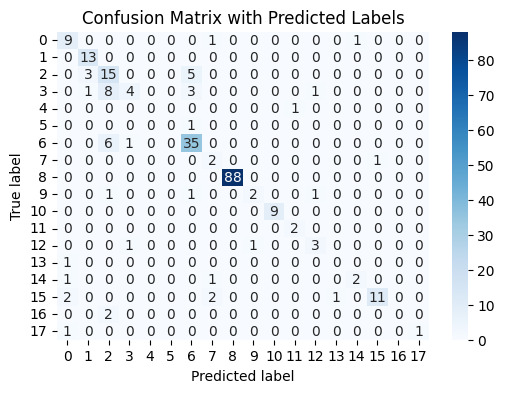

In [326]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix with Predicted Labels')
plt.show()

# Тестирование:

In [327]:
num_features = len(clf.feature_importances_)
print('Number of features:', num_features)

Number of features: 1023


In [328]:
importances = clf.feature_importances_
feature_names = X_train.columns

# Map feature importances to feature names
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

# top 10 features
print(feature_importances.head(10))

        feature  importance
2           A2M    0.025311
263  AC055733.1    0.015570
632       ADTRP    0.015367
412        ACP5    0.014445
873      ALOX15    0.014318
881       ALPK3    0.014284
621      ADRA2B    0.014050
252  AC022819.2    0.012938
557        ADGB    0.012075
411        ACP2    0.011346


In [249]:
expr_сancer = pd.read_csv('/home/iuliiasolomennikova/bostone_gene/Kassandra/deconvolution-to-estimate-immune-cell-subsets//data/LUAD-expr.tsv', sep='\t', index_col=0) 
expr_cell = pd.read_csv('/home/iuliiasolomennikova/bostone_gene/Kassandra/deconvolution-to-estimate-immune-cell-subsets//data/Normal-blood-expr.tsv', sep='\t', index_col=0)

### Для раковых клеток:

In [269]:
expr_сancer.head(3)

,VIC-020-CL,VIC-025-CL,VIC-026-CL,VIC-031-CL,VIC-033-CL,VIC-034-CL
A1BG,0.139650,0.000000,0.000000,0.000000,0.000000,0.000000
A1CF,0.050278,0.041802,0.010439,0.008841,0.006627,0.005353
A2M,166.111953,284.024569,77.175170,43.849792,19.417069,173.169681


In [295]:
LUAD = expr_сancer.T
LUAD.head(3)

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
VIC-020-CL,0.13965,0.050278,166.111953,0.220864,0.153432,6.714810,0.081386,11.871257,8.696697,5.871538,...,13.169343,4.323443,12.412860,18.033103,0.665761,6.845210,105.675717,19.454571,18.236796,9.935738
VIC-025-CL,0.00000,0.041802,284.024569,326.314670,0.835218,54.048979,0.265322,14.094609,15.518646,2.454418,...,18.701137,2.649721,7.208214,14.198499,0.443561,7.915771,129.416355,18.618073,12.569798,19.745376
VIC-026-CL,0.00000,0.010439,77.175170,0.224573,0.147834,1.911275,0.039353,12.882029,15.616836,0.278233,...,15.537623,1.254031,2.694881,5.436411,0.242960,2.580821,68.997328,6.589486,6.378963,4.738366


In [306]:
# Sort the feature importances in descending order
sorted_feat = feature_importances['feature'].tolist()

# Select relevant features from the test LUAD data
test_data_selected = LUAD.loc[:, sorted_feat]


In [304]:
# Select relevant features from the test LUAD data
test_data_selected = LUAD.loc[:, sorted_feat]

# Reorder the columns to match the order of features used to train the model
test_data_selected = test_data_selected.reindex(columns=feature_names)
test_data_selected

y_pred = clf.predict(test_data_selected)
print(y_pred)


['Macrophages' 'Macrophages' 'Macrophages' 'Macrophages' 'CD8_T_cells'
 'Macrophages']


### Для здоровых:

In [307]:
expr_cell.head(3)

,SampleA,SampleB
Gene,,
5S_rRNA,34.911000,52.7754
5_8S_rRNA,0.000000,0.0000
7SK,0.350236,0.0000


In [308]:
NORMAL = expr_cell.T
NORMAL.head(3) 

Gene,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU18,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338
SampleA,34.9110,0.0,0.350236,16.109280,5.933075,0.038071,6.472901,0.977478,1.114301,0.000000,...,0.0,0.0,0.00000,0.0,32.9590,0.0,0.0,10.36762,0.0,110.647690
SampleB,52.7754,0.0,0.000000,19.539665,5.526135,0.046603,7.923150,0.849347,0.412397,0.123665,...,0.0,0.0,2.71479,0.0,10.5042,0.0,0.0,6.12038,0.0,65.794971


In [309]:
# Select relevant features from the test NORMAL data
test_data_selected = NORMAL.loc[:, sorted_feat]

# Reorder the columns to match the order of features used to train the model
test_data_selected = test_data_selected.reindex(columns=feature_names)

y_pred = clf.predict(test_data_selected)
print(y_pred)

['Macrophages' 'Fibroblasts']


# **Второй подход:**

In [4]:
cancer_sample_annot = pd.read_csv('/home/iuliiasolomennikova/bostone_gene/Kassandra/deconvolution-to-estimate-immune-cell-subsets/data/Annotation_cell_lines.tsv', sep='\t', index_col=0)
cancer_expr = pd.read_csv('/home/iuliiasolomennikova/bostone_gene/Kassandra/deconvolution-to-estimate-immune-cell-subsets/data/Expression_cell_lines.tsv', sep='\t', index_col=0)

cells_sample_annot = pd.read_csv('/home/iuliiasolomennikova/bostone_gene/Kassandra/deconvolution-to-estimate-immune-cell-subsets/data/Annotation_cells.tsv', sep='\t', index_col=0)
cells_expr = pd.read_csv('/home/iuliiasolomennikova/bostone_gene/Kassandra/deconvolution-to-estimate-immune-cell-subsets/data/Expression_cells.tsv', sep='\t', index_col=0)

### cancer_sample_annot:

In [5]:
# Drop  last 2 columns in cancer_sample_annot
cancer_sample_annot = cancer_sample_annot.drop(cancer_sample_annot.columns[-2:], axis=1)

In [6]:
# Rename columns 
cancer_sample_annot = cancer_sample_annot.rename(columns={'dataset_h': 'Dataset', 'srr_h': 'Sample'})

In [7]:
# Set index name in cancer_expr as Sample values
cancer_sample_annot.set_index('Sample', drop=False, inplace=True)

# # Drop index name
cancer_sample_annot = cancer_sample_annot.rename_axis(None, axis='index')


In [8]:
cancer_sample_annot.head(2)

,Sample,Dataset,tumor_type
srr_cell_0,srr_cell_0,dataset_cell_0,BRCA
srr_cell_1,srr_cell_1,dataset_cell_0,BRCA


### cancer_expr:

In [469]:
cancer_expr.head(2)

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
srr_cell_0,0.0,0.011732,0.011290,0.093919,0.0,32.224024,0.033204,34.759765,25.760308,0.0,...,13.408904,2.623529,8.559595,11.051684,4.932708,7.602688,41.843930,10.65644,18.877174,14.480296
srr_cell_1,0.0,0.048501,0.013744,0.150548,0.0,14.803060,0.100995,20.656203,24.072333,0.0,...,39.838461,2.435595,10.733455,10.870184,5.901826,12.003573,20.635086,11.64875,13.868637,6.119738


# Итог cancer_expr:

In [9]:
# Transpose to have Gene as rows ans set name of index
cancer_expr = cancer_expr.T
cancer_expr.rename_axis('Gene',  axis='index', inplace=True)
cancer_expr.head(10)

,srr_cell_0,srr_cell_1,srr_cell_2,srr_cell_3,srr_cell_4,srr_cell_5,srr_cell_6,srr_cell_7,srr_cell_8,srr_cell_9,...,srr_cell_224,srr_cell_225,srr_cell_226,srr_cell_227,srr_cell_228,srr_cell_229,srr_cell_230,srr_cell_231,srr_cell_232,srr_cell_233
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.000000,0.000000,0.173913,0.000000,0.000000,0.000000,0.000000,0.093179,0.000000,0.000000,...,0.000000,0.274133,0.250994,0.000000,0.227035,0.000000,0.272656,0.000000,0.000000,0.000000
A1CF,0.011732,0.048501,0.023425,0.043713,0.080633,0.005887,0.057628,0.049083,0.050671,0.000000,...,0.038077,1.276720,0.963579,1.601615,0.761388,0.634379,0.346115,1.309550,0.369429,0.706884
A2M,0.011290,0.013744,0.066401,0.010893,0.020923,0.000000,0.112177,0.000000,0.038031,0.000000,...,158.796192,0.017695,0.010769,0.028417,0.000000,0.000000,0.029175,0.173991,0.061940,0.000000
A2ML1,0.093919,0.150548,0.037020,0.054443,0.233610,0.251769,0.199265,0.016537,0.033009,0.317810,...,0.386994,0.186719,0.168921,0.330798,0.252178,0.295989,0.151696,0.340136,0.261751,0.154915
A3GALT2,0.000000,0.000000,0.000000,0.056374,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.080985,0.000000,0.060516,0.080463,0.000000,0.000000,0.000000,0.000000,0.084712,0.000000
A4GALT,32.224024,14.803060,13.432542,14.979880,33.059343,38.368103,9.542607,11.309837,17.191245,18.175082,...,0.000000,8.044206,8.154228,11.077790,6.543100,5.701691,6.162871,11.895974,6.606917,6.216979
A4GNT,0.033204,0.100995,0.066668,0.326254,0.030702,0.030235,0.182201,0.231881,0.033937,0.032898,...,0.000000,0.575083,0.921744,0.756851,0.995597,1.161421,1.153886,0.558842,1.501892,1.191283
AAAS,34.759765,20.656203,14.590213,27.714933,37.963063,30.348063,12.953143,15.919633,24.353609,23.519369,...,54.715780,48.150710,60.264093,55.603609,35.124294,54.218111,37.486311,62.461615,44.339917,55.425249
AACS,25.760308,24.072333,11.920565,14.324347,24.788841,28.133004,9.889018,10.321884,20.469224,12.214876,...,17.046926,47.354140,53.491876,59.215748,42.885775,46.956746,40.290089,62.340963,46.580466,49.688863


### cells_sample_annot:

In [10]:
# Drop last colums
cells_sample_annot = cells_sample_annot.drop(cells_sample_annot.columns[-1:], axis=1)

In [11]:
# Rename columns 
cells_sample_annot = cells_sample_annot.rename(columns={'dataset_h': 'Dataset', 'general_cell_type': 'Cell_type', 'srr_h': 'Sample'})

In [12]:
# Set index name in cancer_expr as Sample values
cells_sample_annot.set_index('Sample', drop=False, inplace=True)

# # Drop index name
cells_sample_annot = cells_sample_annot.rename_axis(None, axis='index')
cells_sample_annot.head(2)

,Sample,Dataset,Cell_type
srr_0,srr_0,dataset_0,B_cells
srr_1,srr_1,dataset_0,B_cells


# Итог cells_expr:

### cells_expr:

In [13]:
# Transpose to have Gene as rows ans set name of index
cells_expr = cells_expr.T
cells_expr.columns.name = None
cells_expr.rename_axis("Gene", axis='index', inplace=True)
cells_expr.head(10)

,srr_0,srr_1,srr_2,srr_3,srr_4,srr_5,srr_6,srr_7,srr_8,srr_9,...,srr_978,srr_979,srr_980,srr_981,srr_982,srr_983,srr_984,srr_985,srr_986,srr_987
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.283250,0.000000,0.000000,...,0.334078,0.111991,0.000000,0.000000,0.057560,0.000000,0.003237,0.000000,0.000000,0.000000
A1CF,0.105129,0.065913,0.015755,0.037395,0.043908,0.064590,0.073207,0.144928,0.045884,0.012845,...,0.253289,0.008913,0.052548,0.107934,0.014586,0.000000,0.010081,0.014032,0.019239,0.010500
A2M,0.000000,0.000000,0.000000,0.120822,0.000000,0.061918,0.000000,0.000000,0.029344,0.000000,...,0.103331,1.270282,0.933142,0.130263,0.000000,578.288921,193.218463,0.000000,260.470247,360.399656
A2ML1,0.145629,0.281808,0.647224,1.169003,1.060207,1.243510,1.051030,0.958611,0.608066,0.468522,...,0.284617,0.163411,0.187595,0.384112,0.272710,0.094087,0.057072,0.086511,0.329985,0.059811
A3GALT2,0.541486,0.000000,0.000000,0.000000,0.000000,0.000000,0.189186,0.000000,0.480388,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.114963
A4GALT,0.000000,0.056295,0.000000,0.219996,0.221540,0.000000,0.091357,0.122844,0.148067,0.249965,...,0.000000,0.000000,0.000000,0.000000,0.034872,0.000000,0.104782,0.106853,0.299602,0.054568
A4GNT,0.000000,0.000000,0.000000,0.000000,0.000000,0.090061,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.103233,0.000000,0.000000,0.188238,0.057857,0.000000,0.110415,0.060261
AAAS,19.910592,21.188404,20.287175,22.967705,19.753890,23.509959,16.384682,22.519629,22.145114,18.461616,...,6.353120,8.157400,14.919064,9.198163,51.639267,25.165034,25.811112,53.101751,21.432937,25.015718
AACS,1.988836,1.998690,4.018722,3.111907,2.646691,2.345740,2.409119,4.814950,4.915115,1.761001,...,2.634577,3.794859,2.427116,3.234935,34.821651,10.780303,5.689713,22.115892,5.349105,7.424125


In [14]:
cancer_sample_annot.drop(columns=['Sample', 'Dataset'], inplace=True)

In [15]:
cells_sample_annot = cells_sample_annot.drop('Sample', axis=1)
cells_sample_annot.sample(10)

,Dataset,Cell_type
srr_914,dataset_44,Macrophages
srr_845,dataset_52,CD4_T_cells
srr_631,dataset_41,Macrophages
srr_897,dataset_44,Macrophages
srr_535,dataset_38,Macrophages
srr_965,dataset_44,Macrophages
srr_964,dataset_65,CD4_T_cells
srr_476,dataset_37,CD4_T_cells
srr_855,dataset_53,NK_cells
srr_550,dataset_38,Macrophages


### Cоздание смеси:
------------------------
- cells_sample_annot
- cells_expr
-------------------------------------------
- cancer_sample_annot
- cancer_expr
--------------------

In [16]:
cancer_expr

,srr_cell_0,srr_cell_1,srr_cell_2,srr_cell_3,srr_cell_4,srr_cell_5,srr_cell_6,srr_cell_7,srr_cell_8,srr_cell_9,...,srr_cell_224,srr_cell_225,srr_cell_226,srr_cell_227,srr_cell_228,srr_cell_229,srr_cell_230,srr_cell_231,srr_cell_232,srr_cell_233
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.000000,0.000000,0.173913,0.000000,0.000000,0.000000,0.000000,0.093179,0.000000,0.000000,...,0.000000,0.274133,0.250994,0.000000,0.227035,0.000000,0.272656,0.000000,0.000000,0.000000
A1CF,0.011732,0.048501,0.023425,0.043713,0.080633,0.005887,0.057628,0.049083,0.050671,0.000000,...,0.038077,1.276720,0.963579,1.601615,0.761388,0.634379,0.346115,1.309550,0.369429,0.706884
A2M,0.011290,0.013744,0.066401,0.010893,0.020923,0.000000,0.112177,0.000000,0.038031,0.000000,...,158.796192,0.017695,0.010769,0.028417,0.000000,0.000000,0.029175,0.173991,0.061940,0.000000
A2ML1,0.093919,0.150548,0.037020,0.054443,0.233610,0.251769,0.199265,0.016537,0.033009,0.317810,...,0.386994,0.186719,0.168921,0.330798,0.252178,0.295989,0.151696,0.340136,0.261751,0.154915
A3GALT2,0.000000,0.000000,0.000000,0.056374,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.080985,0.000000,0.060516,0.080463,0.000000,0.000000,0.000000,0.000000,0.084712,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,7.602688,12.003573,10.796919,10.901612,5.125028,5.819606,11.620485,11.570371,1.998720,1.508911,...,4.993591,8.164421,6.966180,7.286898,7.320912,8.059396,9.091932,10.201375,7.195026,7.130108
ZYX,41.843930,20.635086,128.795988,134.985322,56.304018,60.734636,107.133219,125.189537,211.794927,188.225785,...,166.988681,93.278217,98.585273,62.589810,57.664841,87.426970,62.897527,65.223731,78.462814,87.019080
ZZEF1,10.656440,11.648750,11.526285,8.312483,8.733390,11.451447,7.992229,11.646786,2.712739,1.791684,...,5.941714,15.863172,18.235226,19.071274,19.013324,16.131541,19.296517,23.908590,14.438191,14.750977


In [17]:
cells_expr

,srr_0,srr_1,srr_2,srr_3,srr_4,srr_5,srr_6,srr_7,srr_8,srr_9,...,srr_978,srr_979,srr_980,srr_981,srr_982,srr_983,srr_984,srr_985,srr_986,srr_987
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.283250,0.000000,0.000000,...,0.334078,0.111991,0.000000,0.000000,0.057560,0.000000,0.003237,0.000000,0.000000,0.000000
A1CF,0.105129,0.065913,0.015755,0.037395,0.043908,0.064590,0.073207,0.144928,0.045884,0.012845,...,0.253289,0.008913,0.052548,0.107934,0.014586,0.000000,0.010081,0.014032,0.019239,0.010500
A2M,0.000000,0.000000,0.000000,0.120822,0.000000,0.061918,0.000000,0.000000,0.029344,0.000000,...,0.103331,1.270282,0.933142,0.130263,0.000000,578.288921,193.218463,0.000000,260.470247,360.399656
A2ML1,0.145629,0.281808,0.647224,1.169003,1.060207,1.243510,1.051030,0.958611,0.608066,0.468522,...,0.284617,0.163411,0.187595,0.384112,0.272710,0.094087,0.057072,0.086511,0.329985,0.059811
A3GALT2,0.541486,0.000000,0.000000,0.000000,0.000000,0.000000,0.189186,0.000000,0.480388,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.114963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ANKRD45,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090517,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072936,0.099277,0.000000,0.000000
ANKRD46,5.970672,5.048407,6.485966,7.761753,5.440542,7.917847,9.122024,8.421421,9.589808,7.115305,...,2.885848,3.765030,3.510859,3.945048,10.893069,14.178662,19.310443,8.626834,13.613108,8.992081
ANKRD49,64.979845,51.063214,62.343704,62.796948,75.620865,64.790046,64.837913,44.998531,47.754864,61.223776,...,92.778488,84.268955,43.116116,144.526581,31.622116,13.001854,10.822753,26.198247,10.234479,16.278355


# Итог экспрессия

In [18]:
expr_feat = cancer_expr.join(cells_expr)
expr_feat

,srr_cell_0,srr_cell_1,srr_cell_2,srr_cell_3,srr_cell_4,srr_cell_5,srr_cell_6,srr_cell_7,srr_cell_8,srr_cell_9,...,srr_978,srr_979,srr_980,srr_981,srr_982,srr_983,srr_984,srr_985,srr_986,srr_987
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.000000,0.000000,0.173913,0.000000,0.000000,0.000000,0.000000,0.093179,0.000000,0.000000,...,0.334078,0.111991,0.000000,0.000000,0.057560,0.000000,0.003237,0.000000,0.000000,0.000000
A1CF,0.011732,0.048501,0.023425,0.043713,0.080633,0.005887,0.057628,0.049083,0.050671,0.000000,...,0.253289,0.008913,0.052548,0.107934,0.014586,0.000000,0.010081,0.014032,0.019239,0.010500
A2M,0.011290,0.013744,0.066401,0.010893,0.020923,0.000000,0.112177,0.000000,0.038031,0.000000,...,0.103331,1.270282,0.933142,0.130263,0.000000,578.288921,193.218463,0.000000,260.470247,360.399656
A2ML1,0.093919,0.150548,0.037020,0.054443,0.233610,0.251769,0.199265,0.016537,0.033009,0.317810,...,0.284617,0.163411,0.187595,0.384112,0.272710,0.094087,0.057072,0.086511,0.329985,0.059811
A3GALT2,0.000000,0.000000,0.000000,0.056374,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.114963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,7.602688,12.003573,10.796919,10.901612,5.125028,5.819606,11.620485,11.570371,1.998720,1.508911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZYX,41.843930,20.635086,128.795988,134.985322,56.304018,60.734636,107.133219,125.189537,211.794927,188.225785,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZZEF1,10.656440,11.648750,11.526285,8.312483,8.733390,11.451447,7.992229,11.646786,2.712739,1.791684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


cells_sample_annot, cancer_sample_annot

In [19]:
cells_sample_annot = cells_sample_annot.drop('Dataset', axis=1)
cells_sample_annot.head(2)

,Cell_type
srr_0,B_cells
srr_1,B_cells


In [20]:
cancer_sample_annot = cancer_sample_annot.rename(columns={'tumor_type': 'Cell_type'})
cancer_sample_annot.head(2)


,Cell_type
srr_cell_0,BRCA
srr_cell_1,BRCA


# Итог аннотация:

In [21]:
merged_df = pd.concat([cells_sample_annot, cancer_sample_annot])
merged_df

,Cell_type
srr_0,B_cells
srr_1,B_cells
srr_2,B_cells
srr_3,B_cells
srr_4,B_cells
...,...
srr_cell_229,LUAD
srr_cell_230,LUAD
srr_cell_231,LUAD
srr_cell_232,LUAD


In [22]:
noisy_df = expr_feat

# Add uniform noise
noisy_df += np.random.uniform(low=0.1, high=0.2, size=noisy_df.shape)

# Add batch effects
num_batches = 3
batch_size = int(noisy_df.shape[1] / num_batches)
for i in range(num_batches):
    noisy_df.iloc[:, i*batch_size:(i+1)*batch_size] += np.random.normal(loc=0, scale=0.1, size=(noisy_df.shape[0], batch_size))

# Make all values positive
noisy_df = np.abs(noisy_df)
noisy_df[noisy_df < 0] = 0


In [23]:
# Generate noisy data with biological noise
noisy_df = expr_feat.copy()

# Add multiplicative biological noise
biological_noise = np.random.normal(loc=1, scale=0.2, size=noisy_df.shape)
noisy_df *= biological_noise

# Add uniform noise
noisy_df += np.random.uniform(low=0.1, high=0.2, size=noisy_df.shape)

# Add batch effects
num_batches = 3
batch_size = int(noisy_df.shape[1] / num_batches)
for i in range(num_batches):
    noisy_df.iloc[:, i*batch_size:(i+1)*batch_size] += np.random.normal(loc=0, scale=0.1, size=(noisy_df.shape[0], batch_size))

# Make all values positive
noisy_df = np.abs(noisy_df)
noisy_df[noisy_df < 0] = 0


In [24]:
noisy_df.describe()
# надо нормализовать!

,srr_cell_0,srr_cell_1,srr_cell_2,srr_cell_3,srr_cell_4,srr_cell_5,srr_cell_6,srr_cell_7,srr_cell_8,srr_cell_9,...,srr_978,srr_979,srr_980,srr_981,srr_982,srr_983,srr_984,srr_985,srr_986,srr_987
count,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,...,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000
mean,50.581157,50.497674,49.831670,50.854852,50.209925,50.491370,50.301537,50.721940,50.036305,51.333096,...,20.062208,19.008387,20.328805,22.337658,48.542414,36.615130,30.518000,40.140250,32.623493,33.138039
std,447.470286,372.827872,408.578911,441.076871,451.608352,466.209712,504.006722,492.943997,332.911180,377.818061,...,153.966095,189.152739,164.165109,172.273484,699.705480,267.806717,207.123740,524.842058,224.219949,206.018861
min,0.000034,0.000203,0.000468,0.000671,0.000048,0.000016,0.000129,0.000619,0.000283,0.000057,...,0.000701,0.000775,0.001052,0.015517,0.001298,0.001982,0.001651,0.000849,0.000068,0.171829
25%,0.457033,0.491270,0.451601,0.437370,0.443080,0.446611,0.434024,0.438679,0.448967,0.433763,...,0.325325,0.327096,0.343586,0.334149,0.337435,0.332146,0.324473,0.347744,0.325290,0.321317
50%,4.638508,4.938636,3.723306,4.059015,3.799779,3.849487,3.433100,3.589800,3.483248,2.557399,...,0.638420,0.602924,0.712259,0.704178,0.777622,0.788864,0.822113,0.783965,0.766908,0.729905
75%,22.761150,25.624974,20.987466,21.824846,20.423080,20.590089,19.467921,20.566792,20.407939,16.123755,...,5.701650,5.078829,6.919587,6.196679,15.079539,15.960565,14.102425,12.700787,14.422057,15.680825
max,23862.135691,18668.142830,29630.916466,30683.452880,29818.870308,27940.423651,45299.183548,43564.345699,18679.228228,14819.629111,...,3984.791968,5154.122424,3859.147275,4575.056170,21204.774882,6393.923600,5213.588753,15464.210045,5648.347090,4379.621384


# нормализация:

In [25]:
# Compute library size factors
lib_size = noisy_df.sum(axis=0)
lib_size_factors = lib_size / np.median(lib_size)

# Normalize by library size and take the log
normed_feat_expr = np.log(noisy_df.divide(lib_size_factors, axis=1) + 1)

normed_feat_expr.describe()

,srr_cell_0,srr_cell_1,srr_cell_2,srr_cell_3,srr_cell_4,srr_cell_5,srr_cell_6,srr_cell_7,srr_cell_8,srr_cell_9,...,srr_978,srr_979,srr_980,srr_981,srr_982,srr_983,srr_984,srr_985,srr_986,srr_987
count,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,2.006200e+04,20062.000000,20062.000000,20062.000000,20062.000000,...,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000
mean,0.391602,0.421105,0.387418,0.388104,0.375096,3.755707e-01,0.368787,0.378635,0.397669,0.359577,...,1.466355,1.456898,1.528101,1.462703,1.307298,1.466414,1.527532,1.366028,1.498736,1.503816
std,0.622968,0.647372,0.639576,0.633405,0.623189,6.224759e-01,0.622764,0.631272,0.669268,0.658768,...,1.488387,1.459287,1.486023,1.499757,1.472163,1.572412,1.588776,1.491661,1.588913,1.588927
min,0.000001,0.000006,0.000015,0.000021,0.000002,5.001129e-07,0.000004,0.000019,0.000009,0.000002,...,0.001077,0.001257,0.001595,0.021194,0.000824,0.001667,0.001667,0.000652,0.000065,0.148326
25%,0.014107,0.015181,0.014149,0.013432,0.013780,1.381225e-02,0.013476,0.013507,0.014010,0.013199,...,0.405482,0.425673,0.419478,0.379305,0.194208,0.246640,0.283562,0.236759,0.268089,0.261589
50%,0.134700,0.143041,0.111080,0.118227,0.112430,1.132200e-01,0.101938,0.105515,0.103873,0.075418,...,0.683729,0.682123,0.732554,0.679085,0.401437,0.509433,0.604682,0.471403,0.545157,0.518313
75%,0.535063,0.586618,0.508160,0.515692,0.494433,4.954297e-01,0.475330,0.493211,0.495495,0.401378,...,2.278645,2.223428,2.441990,2.256941,2.358869,2.670063,2.723968,2.375480,2.683173,2.746681
max,6.610400,6.366949,6.841576,6.856141,6.840338,6.769760e+00,7.256299,7.208960,6.376705,6.120157,...,8.720238,9.031463,8.675006,8.750931,9.508290,8.591500,8.569569,9.382660,8.582945,8.312953


x = normed_feat_expr, y = merged_df

In [26]:
annotation = merged_df.copy()
annotation

,Cell_type
srr_0,B_cells
srr_1,B_cells
srr_2,B_cells
srr_3,B_cells
srr_4,B_cells
...,...
srr_cell_229,LUAD
srr_cell_230,LUAD
srr_cell_231,LUAD
srr_cell_232,LUAD


In [27]:
normed_feat_expr = normed_feat_expr.T
normed_feat_expr

Gene,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
srr_cell_0,0.010517,0.010195,0.006431,0.012141,0.007170,0.493395,0.003845,0.749971,0.570979,0.004934,...,0.446919,0.073507,0.271585,0.307460,0.142440,0.186848,0.805656,0.330226,0.444658,0.427803
srr_cell_1,0.000760,0.002126,0.004192,0.012566,0.010286,0.375988,0.013061,0.460570,0.526181,0.008557,...,0.672147,0.072599,0.336473,0.408721,0.235420,0.335706,0.448165,0.350290,0.318490,0.174015
srr_cell_2,0.009155,0.009645,0.011266,0.013270,0.003760,0.375967,0.012826,0.421568,0.311704,0.325024,...,0.341205,0.030502,0.237913,0.286750,0.069889,0.308997,1.781183,0.289548,0.301728,0.826773
srr_cell_3,0.008774,0.010639,0.000622,0.007487,0.012648,0.480849,0.014522,0.672676,0.389695,0.120092,...,0.644022,0.030907,0.127205,0.281309,0.060470,0.271942,1.494614,0.226218,0.555368,0.600562
srr_cell_4,0.005330,0.012141,0.004210,0.011220,0.002762,0.733221,0.013143,0.807085,0.643095,0.013856,...,0.347275,0.107584,0.264712,0.339776,0.110026,0.174240,0.961033,0.277163,0.264154,0.291474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
srr_983,0.350162,0.153800,5.934343,0.338641,0.305065,0.446537,0.380869,3.349045,2.377383,0.058777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
srr_984,0.281873,0.409544,5.060162,0.062020,0.283311,0.264233,0.414662,3.162101,1.901608,0.307030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
srr_985,0.259628,0.206927,0.165387,0.111427,0.010426,0.223864,0.310506,3.768201,3.129384,0.357328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
srr_986,0.375789,0.406108,5.634014,0.360122,0.263071,0.269865,0.322953,3.055314,2.022987,0.383056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
x = normed_feat_expr.iloc[:, :]
y = annotation['Cell_type']


чтобы распределение целевой переменной в исходном наборе данных сохранялось в обучающих и тестовых наборах 
выберем `stratify=y`

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2023, stratify=y)


# HistGradientBoostingClassifier - Inspired by LightGBM.

During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently. If no missing values were encountered for a given feature during training, then samples with missing values are mapped to whichever child has the most samples.

In [44]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score


hgbc = HistGradientBoostingClassifier(max_iter = 100,
                                      max_depth = 7,
                                      min_samples_leaf = 3
                                     )

hgbc.fit(X_train, y_train)

y_pred = hgbc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Finish...')
print()
print("Accuracy of model: {:.2f}%".format(accuracy*100))


Finish...

Accuracy of model: 29.80%


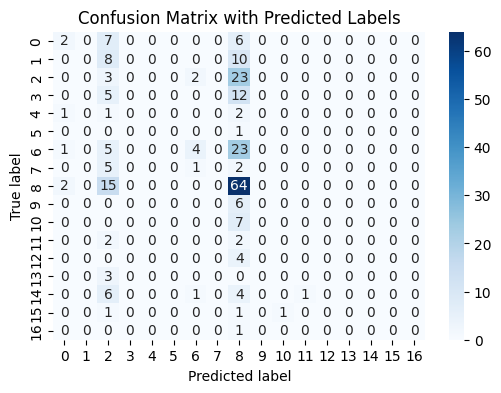

In [45]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix with Predicted Labels')
plt.show() 

### Try SVC with KNNImputer:

In [47]:
# from sklearn.impute import KNNImputer
from sklearn.svm import SVC

imputer = KNNImputer(n_neighbors=5)

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

svm = SVC(C=0.5, kernel='linear', random_state=2023)

svm.fit(X_train_imputed, y_train)

y_pred_svm = svm.predict(X_test_imputed)

accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy of SVM model: {:.2f}%".format(accuracy*100))

Accuracy of SVM model: 70.61%


# Testing:


In [43]:

LUAD = pd.read_csv(data_path + 'LUAD-expr.tsv', sep='\t', index_col=0) 
NORMAL = pd.read_csv(data_path + 'Normal-blood-expr.tsv', sep='\t', index_col=0)

In [81]:
LUAD_expr = LUAD.T
NORMAL_expr = NORMAL

In [56]:
LUAD_imputed = imputer.transform(LUAD_expr)
y_pred_LUAD = svm.predict(LUAD_imputed)

## Predicted types cell/type of cancer for **LUAD-expr.tsv** dataset - samples with Adenocarcinoma

In [66]:
y_pred_LUAD = list(y_pred_LUAD)

In [67]:
lst_id_LUAD = list(LUAD_expr.index)

In [73]:
df_LUAD_pred = pd.DataFrame({'Sample': lst_id_LUAD, 'Predicted cell type/type of cancer': y_pred_LUAD})
df_LUAD_pred

,Sample,Predicted cell type/type of cancer
0,VIC-020-CL,NSCLC
1,VIC-025-CL,PAAD
2,VIC-026-CL,NSCLC
3,VIC-031-CL,NSCLC
4,VIC-033-CL,CD8_T_cells
5,VIC-034-CL,PAAD


## Predicted types cell/type of cancer for **Normal-blood-expr.tsv** dataset - health samples

In [129]:
NORMAL_expr

Gene,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU18,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338
SampleA,34.9110,0.0,0.350236,16.109280,5.933075,0.038071,6.472901,0.977478,1.114301,0.000000,...,0.0,0.0,0.00000,0.0,32.9590,0.0,0.0,10.36762,0.0,110.647690
SampleB,52.7754,0.0,0.000000,19.539665,5.526135,0.046603,7.923150,0.849347,0.412397,0.123665,...,0.0,0.0,2.71479,0.0,10.5042,0.0,0.0,6.12038,0.0,65.794971


In [150]:
# get common features
common_features = NORMAL_expr.columns.intersection(X_train.columns)

# get from NORMAL_expr only these which were passed to X_train
NORMAL_expr_fearured = NORMAL_expr[common_features]


In [151]:
y_pred_NORMAL = svm.predict(NORMAL_expr_fearured)

/home/iuliiasolomennikova/miniconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [153]:
df_NORM_pred = pd.DataFrame({'Sample': NORMAL_expr_featured.index, 'Predicted cell type/type of cancer': y_pred_NORMAL})

df_NORM_pred.set_index('Sample', inplace=True)

df_NORM_pred

,Predicted cell type/type of cancer
Sample,
SampleA,PAAD
SampleB,NSCLC
